In [39]:

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score, ConfusionMatrixDisplay,confusion_matrix, classification_report
import numpy as np


In [40]:
titanic_file_path = "./titanic.csv"
titanic_data = pd.read_csv(titanic_file_path)
#print(titanic_data.head(5))
print("Shape of dataset:",titanic_data.shape)
print("Dataset of data:", titanic_data.info())

Shape of dataset: (891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Dataset of data: None


DATA CLEANING

In [41]:
titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].median())

# Cabin – Categorical (fill with "Unknown Cabin")
titanic_data['Cabin'] = titanic_data['Cabin'].fillna("Unknown Cabin")
missing_data2 = titanic_data.isnull().sum()

print(missing_data2)


PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
dtype: int64


DATA EXPLORATION

In [42]:
print(titanic_data.groupby(['Sex','Survived']).size().unstack(fill_value=0))
titanic_data.groupby('Sex')['Survived'].sum().plot(kind = 'pie',autopct='%1.1f%%')
print("The data shows that Out of all passengers, more females survived than males on the Titanic.\n")


bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
titanic_data['AgeGroup'] = pd.cut(titanic_data['Age'], bins=bins, labels=labels, right=False)

# Step 2: Count survivors by Age Group
age_survival_counts = titanic_data.groupby('AgeGroup',observed=True)['Survived'].sum()

# Step 3: Plot bar chart
plt.figure(figsize=(8,5))
age_survival_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Step 4: Add labels and title
plt.title('Number of Survivors by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Survivors')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 5: Show plot

plt.show()
print("This data shows that people in the age group of 20-29 survived more than others")


Survived    0    1
Sex               
female     81  233
male      468  109
The data shows that Out of all passengers, more females survived than males on the Titanic.



This data shows that people in the age group of 20-29 survived more than others


FEATURE EXTRACTION

In [43]:
titanic_data['Title'] = titanic_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

titanic_data["Deck"] = titanic_data["Cabin"].str[0]

titanic_data['FamilySize'] = titanic_data['SibSp'] + titanic_data['Parch'] + 1  # +1 for the passenger themselves
titanic_data['Deck'] = titanic_data['Deck'].fillna('Unknown')
titanic_data['Embarked'] = titanic_data['Embarked'].fillna('S')
titanic_data['Title'] = titanic_data['Title'].fillna('Unknown')



DATA PREPROCESSING

In [44]:
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 1, 'female': 0})


#X = pd.get_dummies(titanic_data, columns=['Embarked','Deck'])
categorical_cols = ['Embarked', 'Deck', 'Title']  # One-hot encode these
titanic_data = pd.get_dummies(titanic_data, columns=categorical_cols, drop_first=True)

FEATURE SELECTION

In [45]:

#Print out the target value to be predicted 
y = titanic_data.Survived
#Features of target to be predicted
X = titanic_data.drop(columns=['Survived','Name','Cabin','Ticket','AgeGroup'],errors='ignore')  # drop target & useless columns

DATA SPLIT

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)


LOG MODEL


In [47]:
log_model = LogisticRegression(random_state=1,max_iter=5000)
#fit the model 
log_model.fit(X_train, y_train)
#Prediction
log_y_pred = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, log_y_pred)#
print("Accuracy for the logisticRegression:", log_accuracy)

Accuracy for the logisticRegression: 0.8100558659217877


Random Model

In [48]:
#Define The Model
rf_model = RandomForestClassifier(random_state=42)
#Fit the model
rf_model.fit(X_train, y_train)
#Prediction
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print("Accuracy for the RandomForestRegressor:",rf_accuracy )


Accuracy for the RandomForestRegressor: 0.8435754189944135


XGBOOST Model

In [49]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
#hprint(xgb_y_pred)
xgb_accuracy = accuracy_score(y_test, rf_y_pred)
print('XGBOOST ACCURACY:', xgb_accuracy)

XGBOOST ACCURACY: 0.8435754189944135


FEATURE PERFORMANCE

In [50]:
print("Feature performance for log model")
log_coef = pd.Series(log_model.coef_[0], index=X_train.columns)
log_coef = log_coef.sort_values(key=abs, ascending=False)  # absolute effect
print("Logistic Regression Feature Coefficients:\n", log_coef)

print("Feature performance for RandomForest model")
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)

#print("Feature performance for XGBOOSTmodel")
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
xgb_importance = xgb_importance.sort_values(ascending=False)
print("XGBoost Feature Importance:\n", xgb_importance)


Feature performance for log model
Logistic Regression Feature Coefficients:
 Sex              -1.480799
Title_Master      1.469704
Title_Mr         -1.351438
Deck_E            1.133141
Title_Mrs         1.086095
Title_Rev        -0.809398
Deck_G           -0.791202
Deck_D            0.683630
Pclass           -0.629750
Embarked_S       -0.453018
Deck_U           -0.378826
Deck_F            0.344988
Title_Dr         -0.305259
FamilySize       -0.271145
Deck_B            0.237234
Deck_T           -0.230618
Title_Ms          0.207886
SibSp            -0.203551
Deck_C           -0.190457
Embarked_Q       -0.162095
Title_Lady        0.135703
Title_Miss       -0.115019
Title_Major      -0.094863
Parch            -0.093249
Title_Mlle        0.090343
Title_Countess    0.062766
Title_Mme         0.038681
Title_Col        -0.031817
Age              -0.026044
Fare              0.004760
PassengerId       0.000229
Title_Don         0.000000
Title_Jonkheer    0.000000
Title_Sir         0.000000
dtype

FEATURE SELECTION

In [51]:
#For Log Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#For RandomForest MOdel
top_features = feature_importance.head(10).index
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

#For Xgboost Model
top_xgb_features = xgb_importance.head(10).index
X_xgb_train = X_train[top_xgb_features]
X_xgb_test = X_test[top_xgb_features]

RETRAINED LOG MODEL

Logistic Regression: Train = 0.8426966292134831  Test = 0.8156424581005587
Logistic Regression F1 Score: 0.7785234899328859


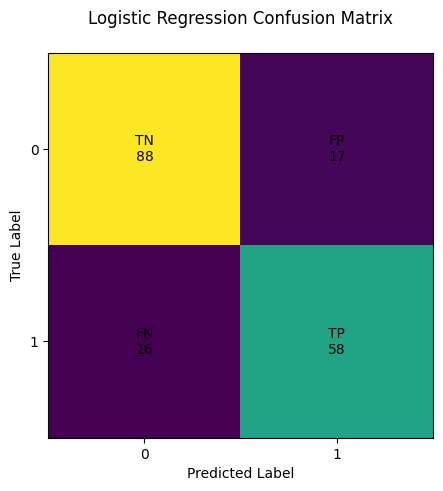

In [64]:
# LogisticRegression
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
#print("Logistic Regression Accuracy for Test data (Top Features):", accuracy_score(y_test, y_pred_log))
y_log_pred = log_model.predict(X_train_scaled)
#print("Logistic Regression Accuracy for Train data", accuracy_score(y_train,y_log_pred))

print("Logistic Regression: Train =", accuracy_score(y_train,y_log_pred), " Test =", accuracy_score(y_test, y_pred_log))

f1_log = f1_score(y_test, y_pred_log)
print("Logistic Regression F1 Score:", f1_log)

cm_log = confusion_matrix(y_test, y_pred_log)

fig, ax = plt.subplots( figsize=(5, 5))

im = ax.imshow(cm_log) 
ax.set_title("Logistic Regression Confusion Matrix\n")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"])
ax.set_yticklabels(["0", "1"])

# STEP 5: Add TN, FP, FN, TP labels inside the squares
labels = [["TN", "FP"], ["FN", "TP"]]  # positions
for i in range(2):           # loop over rows
    for j in range(2):       # loop over columns
        text = f"{labels[i][j]}\n{cm_log[i, j]}"   # e.g. "TP\n45"
        ax.text(j, i, text, ha="center", va="center", color="black")
#print("Confusion Matrix Logistic Regression:\n", cm_log)

RETRAINED RANDOM MODEL

Random Forest: Train = 1.0  Test = 0.8268156424581006
Random Forest F1 Score: 0.7862068965517242


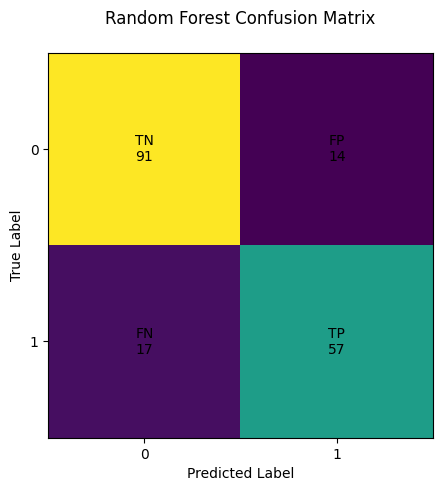

In [ ]:
# RandomForest
rf_model.fit(X_train_top, y_train)
y_pred_rf_top = rf_model.predict(X_test_top)
#print("RandomForest Accuracy for Test Data (Top Features):", accuracy_score(y_test, y_pred_rf_top))
y_rf_pred = rf_model.predict(X_train_top)
#print("RandomForest Accuracy for Train data", accuracy_score(y_train,y_rf_pred))

print("Random Forest: Train =", accuracy_score(y_train,y_rf_pred), " Test =", accuracy_score(y_test, y_pred_rf_top))

f1_rf = f1_score(y_test, y_pred_rf_top)
print("Random Forest F1 Score:", f1_rf)

cm_rf = confusion_matrix(y_test, y_pred_rf_top)

fig, ax = plt.subplots(figsize=(5, 5))

#ConfusionMatrixDisplay(cm_rf).plot(ax=ax, colorbar=False)

im = ax.imshow(cm_rf) 
ax.set_title("Random Forest Confusion Matrix\n")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"])
ax.set_yticklabels(["0", "1"])

# STEP 5: Add TN, FP, FN, TP labels inside the squares
labels = [["TN", "FP"], ["FN", "TP"]]  # positions
for i in range(2):           # loop over rows
    for j in range(2):       # loop over columns
        text = f"{labels[i][j]}\n{cm_rf[i, j]}"   # e.g. "TP\n45"
        ax.text(j, i, text, ha="center", va="center", color="black")
#print("Confusion Matrix Random Forest:\n", cm_rf)

RETRAINED XGBOOST MODEL

XGBOOST Model: Train = 0.9241573033707865  Test = 0.8324022346368715
XGBoost F1 Score: 0.7916666666666666


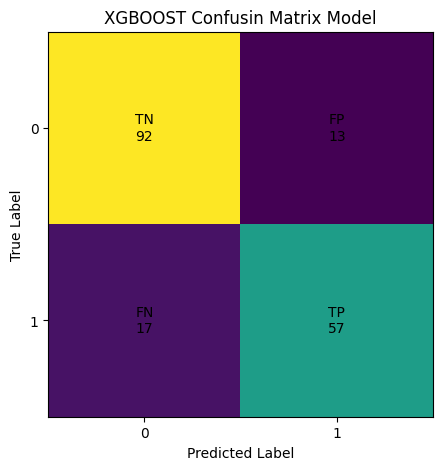

In [ ]:
# XGBoost
xgb_model.fit(X_xgb_train, y_train)
y_pred_xgb_top = xgb_model.predict(X_xgb_test)
y_pred = xgb_model.predict(X_xgb_train)
#print("XGBOOST Acuracy for train data", accuracy_score(y_train, y_pred))
#print("XGBoost Accuracy (Top Features):", accuracy_score(y_test, y_pred_xgb_top))

print("XGBOOST Model: Train =", accuracy_score(y_train,y_pred), " Test =", accuracy_score(y_test, y_pred_xgb_top))

f1_xgb = f1_score(y_test, y_pred_xgb_top)
print("XGBoost F1 Score:", f1_xgb)

cm_xgb = confusion_matrix(y_test, y_pred_xgb_top)

fig, ax = plt.subplots(figsize=(5, 5))

im = ax.imshow(cm_xgb) 

ax.set_title("XGBOOST Confusin Matrix Model")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# tick labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"])
ax.set_yticklabels(["0", "1"])

# STEP 5: Add TN, FP, FN, TP labels inside the squares
labels = [["TN", "FP"], ["FN", "TP"]]  # positions
for i in range(2):           # loop over rows
    for j in range(2):       # loop over columns
        text = f"{labels[i][j]}\n{cm_xgb[i, j]}"  
        ax.text(j, i, text, ha="center", va="center", color="black")
#print("Confusion Matrix XGBoost:\n", cm_xgb)

PERFORMANCE OF MODELS

In [55]:
#Performance between models
print("\nModel Comparison:")
print(f"Logistic Regression: {log_accuracy:.4f}")
print(f"Random Forest      : {rf_accuracy:.4f}")
print(f"XGBoost            : {xgb_accuracy:.4f}")


Model Comparison:
Logistic Regression: 0.8101
Random Forest      : 0.8436
XGBoost            : 0.8436
